In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, 0.001)
model.add_layer(DenseLayer(1, 8, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(3, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 100,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-1, 1],
    c1 = [0.1, 2.0],
    c2 = [0.5, 2.0],
    w = 1.2,
    w_decay = 0.95))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'essential_metrics','categorical_crossentropy'])

building layer 1 with 5
48
building layer 2 with 8
36
building layer 3 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 300
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)


In [8]:
# learning phase
history = model.fit(x_train, y_train, EPOCHS)


update local, 0.63266682847638
update global 0.6192040844498393
update local, 0.6542933098623686
Iteration 128/300: 	0.6192040844498393
update local, 0.6752417020708601
update local, 0.6459473939699547
update local, 0.6474123090227074
update global 0.6192040844498393
Iteration 129/300: 	0.6192040844498393
update local, 0.6607730901129892
update local, 0.6562880756699037
update global 0.6192040844498393
update local, 0.6458706722081264
Iteration 130/300: 	0.6192040844498393
update local, 0.6539875636590975
update local, 0.6503956874954366
update local, 0.6415621320777964
update local, 0.630960910119743
update global 0.6192040844498393
update local, 0.6900219070577176
Iteration 131/300: 	0.6192040844498393
update local, 0.6252944803683558
update local, 0.6327479710088713
update local, 0.6913994049357477
update global 0.6192040844498393
update local, 0.6412832670122663
update local, 0.6458698165750949
Iteration 132/300: 	0.6192040844498393
update local, 0.6644718491028403
update local, 0

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()



In [10]:
print(history)

[0.7619134065146759, 0.7619134065146759, 0.7619134065146759, 0.7619134065146759, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7306458660375292, 0.7139978141428154, 0.7139978141428154, 0.7139978141428154, 0.7139978141428154, 0.7011295211649387, 0.7011295211649387, 0.7011295211649387, 0.7011295211649387, 0.7011295211649387, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.652299613596123, 0.6422073506863317, 0.6422073506863317, 0.6422073506863317, 0.6422073506863317, 0.6422073506863317, 0.6422073506863317, 0.6422073506863317, 0.6374319914345429, 0.6374319914345429, 0.6374319914345429, 0.6374319914345429, 0.6374319914345429, 0.6374319914345429, 0.6374319914345

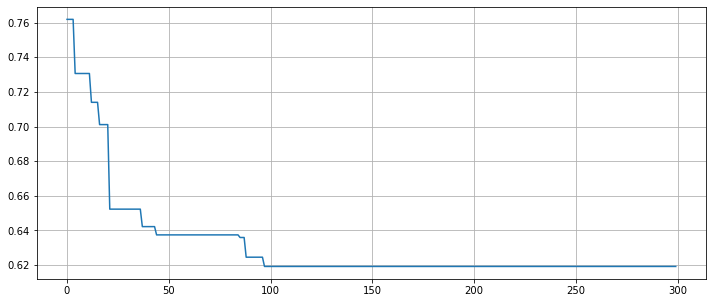

In [11]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.92303085]
 [0.0566422 ]
 [0.02032691]]
[1. 0. 0.] <-> [[0.9197305 ]
 [0.05885701]
 [0.02141255]]
[1. 0. 0.] <-> [[0.4633235 ]
 [0.28225476]
 [0.25442174]]
[1. 0. 0.] <-> [[0.92267096]
 [0.05688159]
 [0.02044738]]
[0. 0. 1.] <-> [[0.42672518]
 [0.28999305]
 [0.28328177]]
[0. 0. 1.] <-> [[0.07274874]
 [0.3833223 ]
 [0.543929  ]]
[1. 0. 0.] <-> [[0.71854174]
 [0.20265602]
 [0.07880219]]
[1. 0. 0.] <-> [[0.37118372]
 [0.30213895]
 [0.32667732]]
[1. 0. 0.] <-> [[0.6503141 ]
 [0.23299679]
 [0.11668909]]
[1. 0. 0.] <-> [[0.8581587 ]
 [0.09758567]
 [0.04425561]]
[1. 0. 0.] <-> [[0.86400115]
 [0.10161974]
 [0.03437918]]
[1. 0. 0.] <-> [[0.7533227 ]
 [0.18220308]
 [0.06447417]]
[1. 0. 0.] <-> [[0.88625526]
 [0.08050974]
 [0.033235  ]]
[0. 1. 0.] <-> [[0.01098283]
 [0.4013866 ]
 [0.5876305 ]]
[0. 1. 0.] <-> [[0.76809883]
 [0.17244944]
 [0.05945174]]
[1. 0. 0.] <-> [[0.8945899 ]
 [0.07527087]
 [0.0301393 ]]
[1. 0. 0.] <-> [[0.9063542 ]
 [0.06771547]
 [0.02593036]]
[1. 0. 0.] <->